<a href="https://colab.research.google.com/github/jaredlan1/getting_started_with_ML/blob/main/HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
import numpy as np
import math
import matplotlib.pyplot as plt


In [17]:
# -------- activation functions -------
def relu(z):
    return np.maximum(0, z)


def relu_back(xbar, z):
   return xbar * (z > 0)

identity = lambda z: z

identity_back = lambda xbar, z: xbar
# -------------------------------------------

In [18]:
# ---------- initialization -----------
def initialization(nin, nout):
    W = np.random.randn(nout, nin)# /np.sqrt(nin)
    b = np.zeros((nout, 1))
    return W, b
# -------------------------------------


# -------- loss functions -----------
def mse(yhat, y):
    diff = yhat-y
    sq = diff**2
    mse = np.mean(sq)
    return mse

def mse_back(yhat, y):

    # derivative of y of mse
    #diff = yhat-y
    #n = y.shape[0]
    #return  2*(diff) / n
    return 2 * (yhat - y) / y.size
# -----------------------------------

In [19]:
# ------------- Layer ------------
class Layer:
    def __init__(self, nin, nout, activation=identity):
        self.W = np.random.rand(nout, nin)
        self.b = np.zeros((nout, 1))

        self.activation = activation
        if activation == relu:
            self.activation_back = relu_back
        if activation == identity:
            self.activation_back = identity_back

        self.Wbar = None
        self.bbar = None

        self.X_cache = None
        self.Z_cache = None

    def forward(self, X, train=True):
        #Z = X @ self.W + self.b
        Z = self.W @ X + self.b
        Xnew = self.activation(Z)

        if train:
            self.X_cache = X
            self.Z_cache = Z

        return Xnew

    def backward(self, Xnewbar):
        Zbar = self.activation_back(Xnewbar, self.Z_cache)

        ns = self.X_cache.shape[1]

        #self.Wbar = self.X_cache.T @ Zbar
        self.Wbar = (Zbar @ self.X_cache.T) #/ ns
        #self.bbar = np.sum(Zbar, axis=0, keepdims=True)
        self.bbar = np.sum(Zbar, axis=1, keepdims=True) #/ ns

        #Xbar = Zbar @ self.W.T
        Xbar = self.W.T @ Zbar
        return Xbar

In [20]:
class Network:
    def __init__(self, layers, loss):
        self.layers = layers

        if loss == mse:
            self.loss_back = mse_back

        # caches
        self.yhat_cache = None
        self.y_cache = None

    def forward(self, X, y, train=True):
        # propagate input through layers
        for layer in self.layers:
            X = layer.forward(X, train=train)

        yhat = X
        L = mse(yhat, y)

        if train:
            self.yhat_cache = yhat
            self.y_cache = y

        return L, yhat

    def backward(self):
        # start from loss gradient
        Lbar = self.loss_back(self.yhat_cache, self.y_cache)

        # backprop through layers
        for layer in reversed(self.layers):
            Lbar = layer.backward(Lbar)



In [21]:
class GradientDescent:

    def __init__(self, alpha):
        self.alpha = alpha

    def step(self, network):
        for layer in network.layers:

          layer.W -= self.alpha * layer.Wbar
          layer.b -= self.alpha * layer.bbar


if __name__ == '__main__':

    # ---------- data preparation ----------------
    # Initialize lists for the numeric data and the string data
    numeric_data = []

    # Read the text file
    with open('/content/drive/MyDrive/Physics Informed ML/HW/auto_mpg/auto-mpg.data', 'r') as file:
        for line in file:
            # Split the line into columns
            columns = line.strip().split()

            # Check if any of the first 8 columns contain '?'
            if '?' in columns[:8]:
                continue  # Skip this line if there's a missing value

            # Convert the first 8 columns to floats and append to numeric_data
            numeric_data.append([float(value) for value in columns[:8]])

    # Convert numeric_data to a numpy array for easier manipulation
    numeric_array = np.array(numeric_data)


avg error (mpg) = 3.4479842628575126


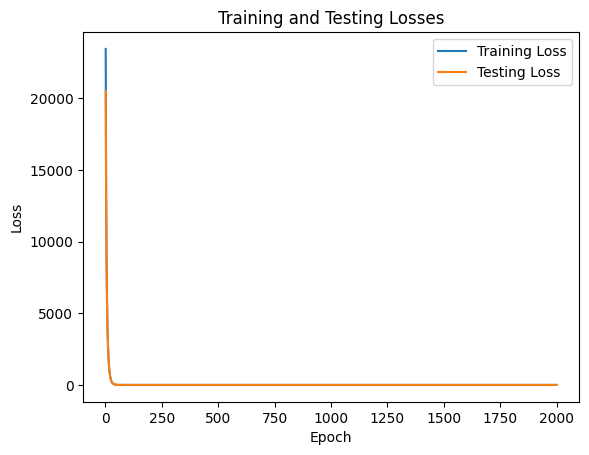

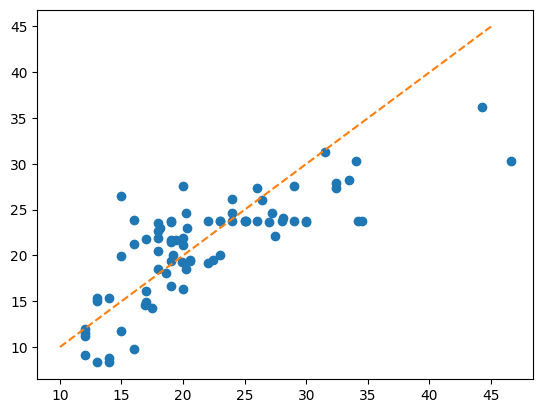

In [36]:
# Shuffle the numeric array and the corresponding string array
nrows = numeric_array.shape[0]
indices = np.arange(nrows)
np.random.shuffle(indices)
shuffled_numeric_array = numeric_array[indices]

# Split into training (80%) and test (20%) sets
split_index = int(0.8 * nrows)

train_numeric = shuffled_numeric_array[:split_index]
test_numeric = shuffled_numeric_array[split_index:]

# separate inputs/outputs
Xtrain = train_numeric[:, 1:]
ytrain = train_numeric[:, 0]

Xtest = test_numeric[:, 1:]
ytest = test_numeric[:, 0]

# normalize
Xmean = np.mean(Xtrain, axis=0)
Xstd = np.std(Xtrain, axis=0)
ymean = np.mean(ytrain)
ystd = np.std(ytrain)

Xtrain = (Xtrain - Xmean) / Xstd
Xtest = (Xtest - Xmean) / Xstd
ytrain = (ytrain - ymean) / ystd
ytest = (ytest - ymean) / ystd

    # reshape arrays (opposite order of pytorch, here we have nx x ns).
    # I found that to be more conveient with the way I did the math operations, but feel free to setup
    # however you like.
Xtrain = Xtrain.T
Xtest = Xtest.T
ytrain = np.reshape(ytrain, (1, len(ytrain)))
ytest = np.reshape(ytest, (1, len(ytest)))

    # ------------------------------------------------------------

l1 = Layer(7, 32, relu)
l2 = Layer(32, 16, relu)
l3 = Layer(16, 1, identity)
layers = [l1, l2, l3]
network = Network(layers, mse)
alpha = 1e-5
optimizer = GradientDescent(alpha)

train_losses = []
test_losses = []
epochs = 2000
for i in range(epochs):
        # TODO: run train set, backprop, step
        train_loss, _ = network.forward(Xtrain, ytrain, train=True)
        network.backward()                 # compute Wbar, bbar for all layers
        optimizer.step(network)            # apply updates
        train_losses.append(train_loss)
        # TODO: run test set
        test_loss, _ = network.forward(Xtest, ytest, train=False)
        test_losses.append(test_loss)

    # --- inference ----
        _, yhat = network.forward(Xtest, ytest, train=False)

    # unnormalize
yhat = (yhat * ystd) + ymean
ytest = (ytest * ystd) + ymean

plt.figure()
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), test_losses, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Losses')
plt.legend()


plt.figure()
plt.plot(ytest.T, yhat.T, "o")
plt.plot([10, 45], [10, 45], "--")

print("avg error (mpg) =", np.mean(np.abs(yhat - ytest)))

plt.show()

In [24]:
# ===== Debug cell (works with your current notebook definitions) =====
import numpy as np
import importlib.util

# ---- Reference weights/biases (given in the handout) ----
l1_W_ref = np.array([
    [0.34710014, 0.45232547],
    [0.38122103, 0.34461438],
    [0.26794282, 0.40849930],
])
l1_b_ref = np.zeros((3, 1))

l2_W_ref = np.array([[0.30942088, 0.63057874, 0.68141247]])
l2_b_ref = np.zeros((1, 1))

# ---- Data (given in the handout) ----
ns = 10
X = np.ones((2, ns))
y = np.ones((1, ns))

# ---- Build layers using whatever Layer class is currently in your notebook ----
l1 = Layer(2, 3, activation=identity)
l2 = Layer(3, 1, activation=identity)

# Force EXACT weights and biases
l1.W, l1.b = l1_W_ref.copy(), l1_b_ref.copy()
l2.W, l2.b = l2_W_ref.copy(), l2_b_ref.copy()

# ---- Forward ----
Z1 = l1.forward(X)
yhat = l2.forward(Z1)
loss = mse(yhat, y)

print("Forward check")
print("yhat[0,0] =", float(yhat[0,0]), " (expected ~ 1.16599146)")
print("loss     =", float(loss),      " (expected ~ 0.02755316457552718)")

# ---- Backward ----
yhat_bar = mse_back(yhat, y)      # dL/dyhat
Z1_bar   = l2.backward(yhat_bar)  # dL/dZ1
_        = l1.backward(Z1_bar)    # fills l1.Wbar/l1.bbar

print("\nBackward check (your computed gradients)")
print("l1.Wbar =\n", l1.Wbar)
print("l1.bbar =\n", l1.bbar)
print("l2.Wbar =\n", l2.Wbar)
print("l2.bbar =\n", l2.bbar)

# ---- Reference gradients from the handout ----
l1_Wbar_ref = np.array([
    [0.10272245, 0.10272245],
    [0.20934137, 0.20934137],
    [0.22621730, 0.22621730],
])
l1_bbar_ref = np.array([
    [0.10272245],
    [0.20934137],
    [0.22621730],
])
l2_Wbar_ref = np.array([[0.26539565, 0.24096496, 0.22456723]])
l2_bbar_ref = np.array([[0.33198292]])

print("\nMatches handout?")
print("loss ok  :", np.isclose(loss, 0.02755316457552718, rtol=1e-6, atol=1e-8))
print("yhat ok  :", np.isclose(yhat[0,0], 1.16599146, rtol=1e-6, atol=1e-8))
print("l1.Wbar  :", np.allclose(l1.Wbar, l1_Wbar_ref, rtol=1e-6, atol=1e-8))
print("l1.bbar  :", np.allclose(l1.bbar, l1_bbar_ref, rtol=1e-6, atol=1e-8))
print("l2.Wbar  :", np.allclose(l2.Wbar, l2_Wbar_ref, rtol=1e-6, atol=1e-8))
print("l2.bbar  :", np.allclose(l2.bbar, l2_bbar_ref, rtol=1e-6, atol=1e-8))

# extra: handout mentions this should be 0.03319829 repeated (dL/dyhat element)
print("\ndL/dyhat element =", float(yhat_bar[0,0]), " (expected ~ 0.03319829)")

Forward check
yhat[0,0] = 1.1659914498271566  (expected ~ 1.16599146)
loss     = 0.027553161415721457  (expected ~ 0.02755316457552718)

Backward check (your computed gradients)
l1.Wbar =
 [[0.10272244 0.10272244]
 [0.20934136 0.20934136]
 [0.22621729 0.22621729]]
l1.bbar =
 [[0.10272244]
 [0.20934136]
 [0.22621729]]
l2.Wbar =
 [[0.26539563 0.24096494 0.22456722]]
l2.bbar =
 [[0.3319829]]

Matches handout?
loss ok  : True
yhat ok  : True
l1.Wbar  : True
l1.bbar  : True
l2.Wbar  : True
l2.bbar  : True

dL/dyhat element = 0.033198289965431324  (expected ~ 0.03319829)
